In [ ]:
pip install memory_profiler

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import psutil
# import resource
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report

In [ ]:
# Define the image size
import os
IMG_SIZE = 50

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/CSV


# train_df = pd.read_csv("./train_feature_index.csv")
# test_df = pd.read_csv("./test_feature_index.csv")
train_df = pd.read_csv("./train_final_index.csv")
test_df = pd.read_csv("./test_final_index.csv")


path = "/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/fiveTwelve"
print("found", os.path.exists(path=path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/CSV
found True


<ipython-input-36-0fa5376ceba4>:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


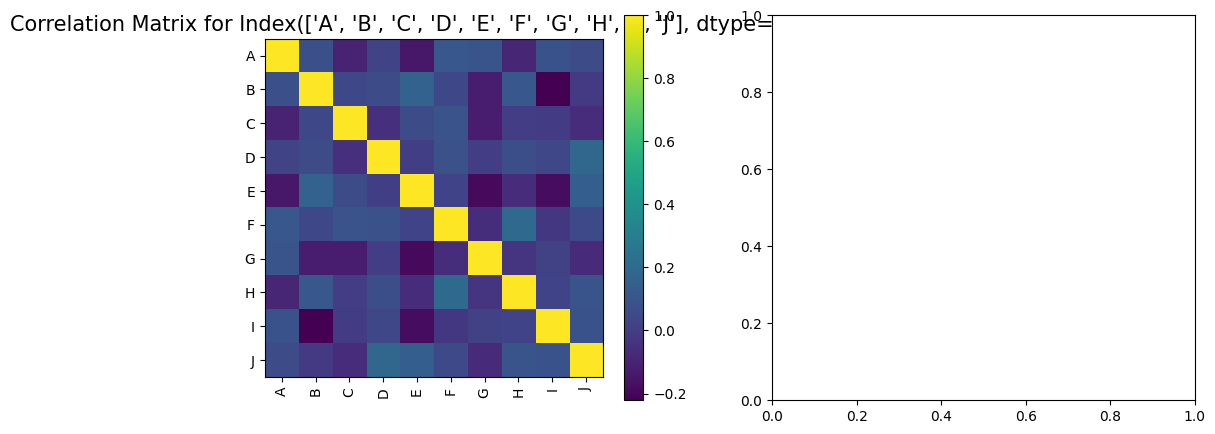

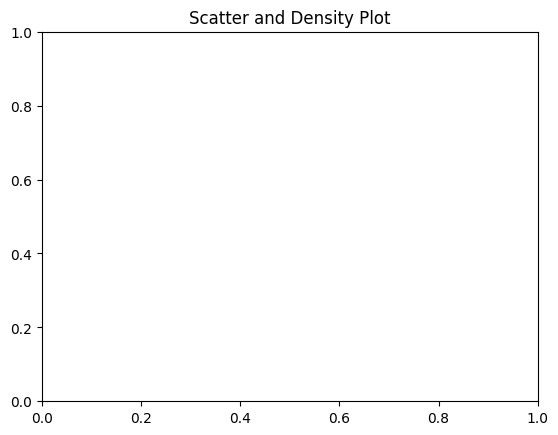

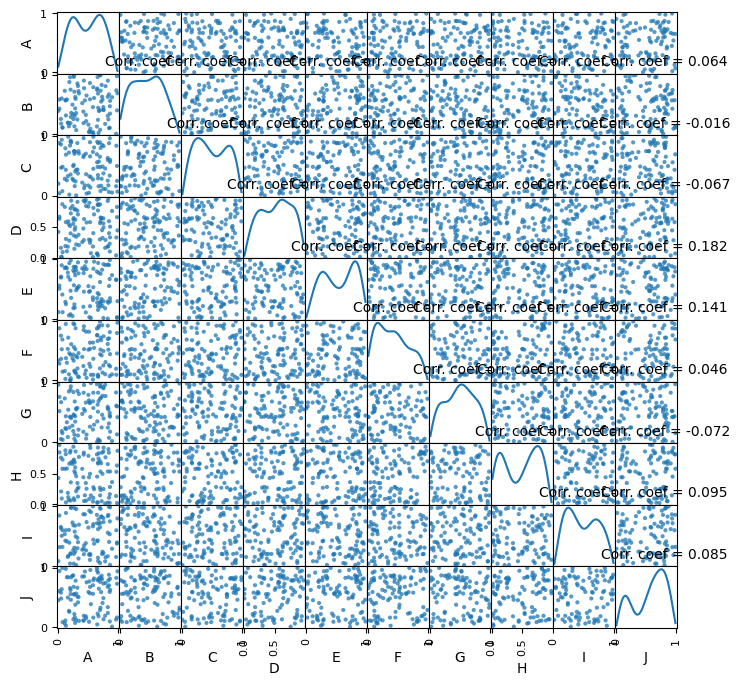

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample DataFrame for illustration
data = {'A': np.random.rand(100),
        'B': np.random.rand(100),
        'C': np.random.rand(100),
        'D': np.random.rand(100),
        'E': np.random.rand(100),
        'F': np.random.rand(100),
        'G': np.random.rand(100),
        'H': np.random.rand(100),
        'I': np.random.rand(100),
        'J': np.random.rand(100)}

df = pd.DataFrame(data)

# Correlation matrix
def plotCorrelationMatrix(ax, df, graphWidth):
    filename = df.columns
    df = df.dropna(axis='columns')  # drop columns with NaN
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    corrMat = ax.matshow(corr, cmap='viridis')
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.columns)
    ax.xaxis.tick_bottom()
    plt.colorbar(corrMat, ax=ax)
    ax.set_title(f'Correlation Matrix for {filename}', fontsize=15)

# Scatter plot matrix
def plotScatterMatrix(ax, df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    df = df.dropna(axis='columns')
    columnNames = list(df)
    scatter_matrix = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(scatter_matrix, k=1)):
        scatter_matrix[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    ax.set_title('Scatter and Density Plot')

# Example usage
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Use your actual DataFrame instead of 'your_dataframe'
plotCorrelationMatrix(axes[0], df, graphWidth=6)

# Create a new figure for the scatter plot matrix
fig_scatter = plt.figure()
ax_scatter = fig_scatter.add_subplot(111)
plotScatterMatrix(ax_scatter, df, plotSize=8, textSize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
X_train = train_df.drop(columns=["label", "path"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "path"])
y_test = test_df["label"]

# plotCorrelationMatrix(train_df, 8)
# plotScatterMatrix(train_df, 20, 10)

def load_and_preprocess_image(path):
    image = cv2.imread(path)
    if(image is not None):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0
      return image

<ipython-input-9-d59d57811f12>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN
<ipython-input-9-d59d57811f12>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


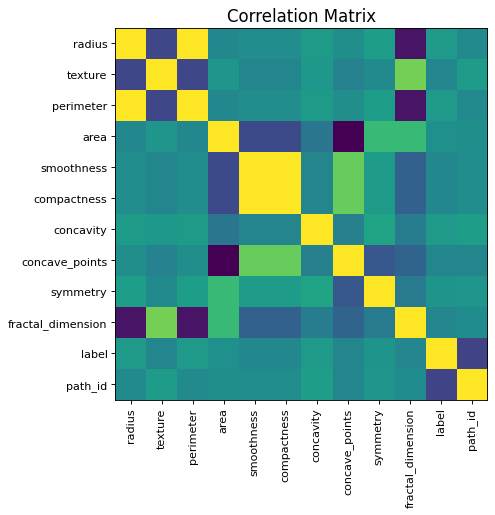

<ipython-input-9-d59d57811f12>:23: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


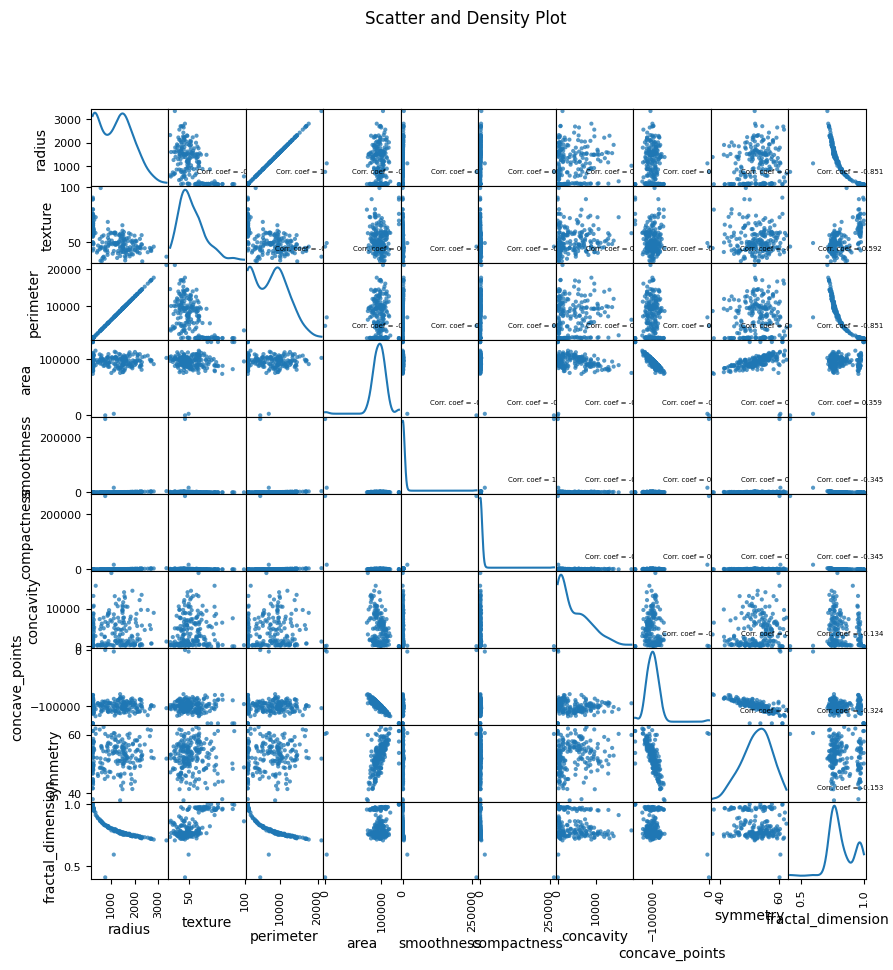

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.columns
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    # plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
plotCorrelationMatrix(train_df, 6)
plotScatterMatrix(train_df, 10,5)

<ipython-input-9-d59d57811f12>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN
<ipython-input-9-d59d57811f12>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


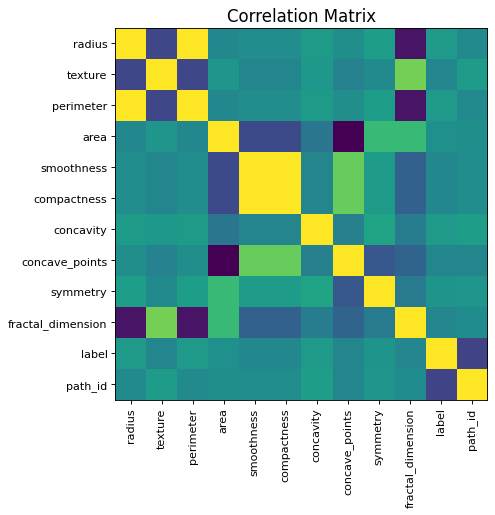

<ipython-input-14-96603c193ef6>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


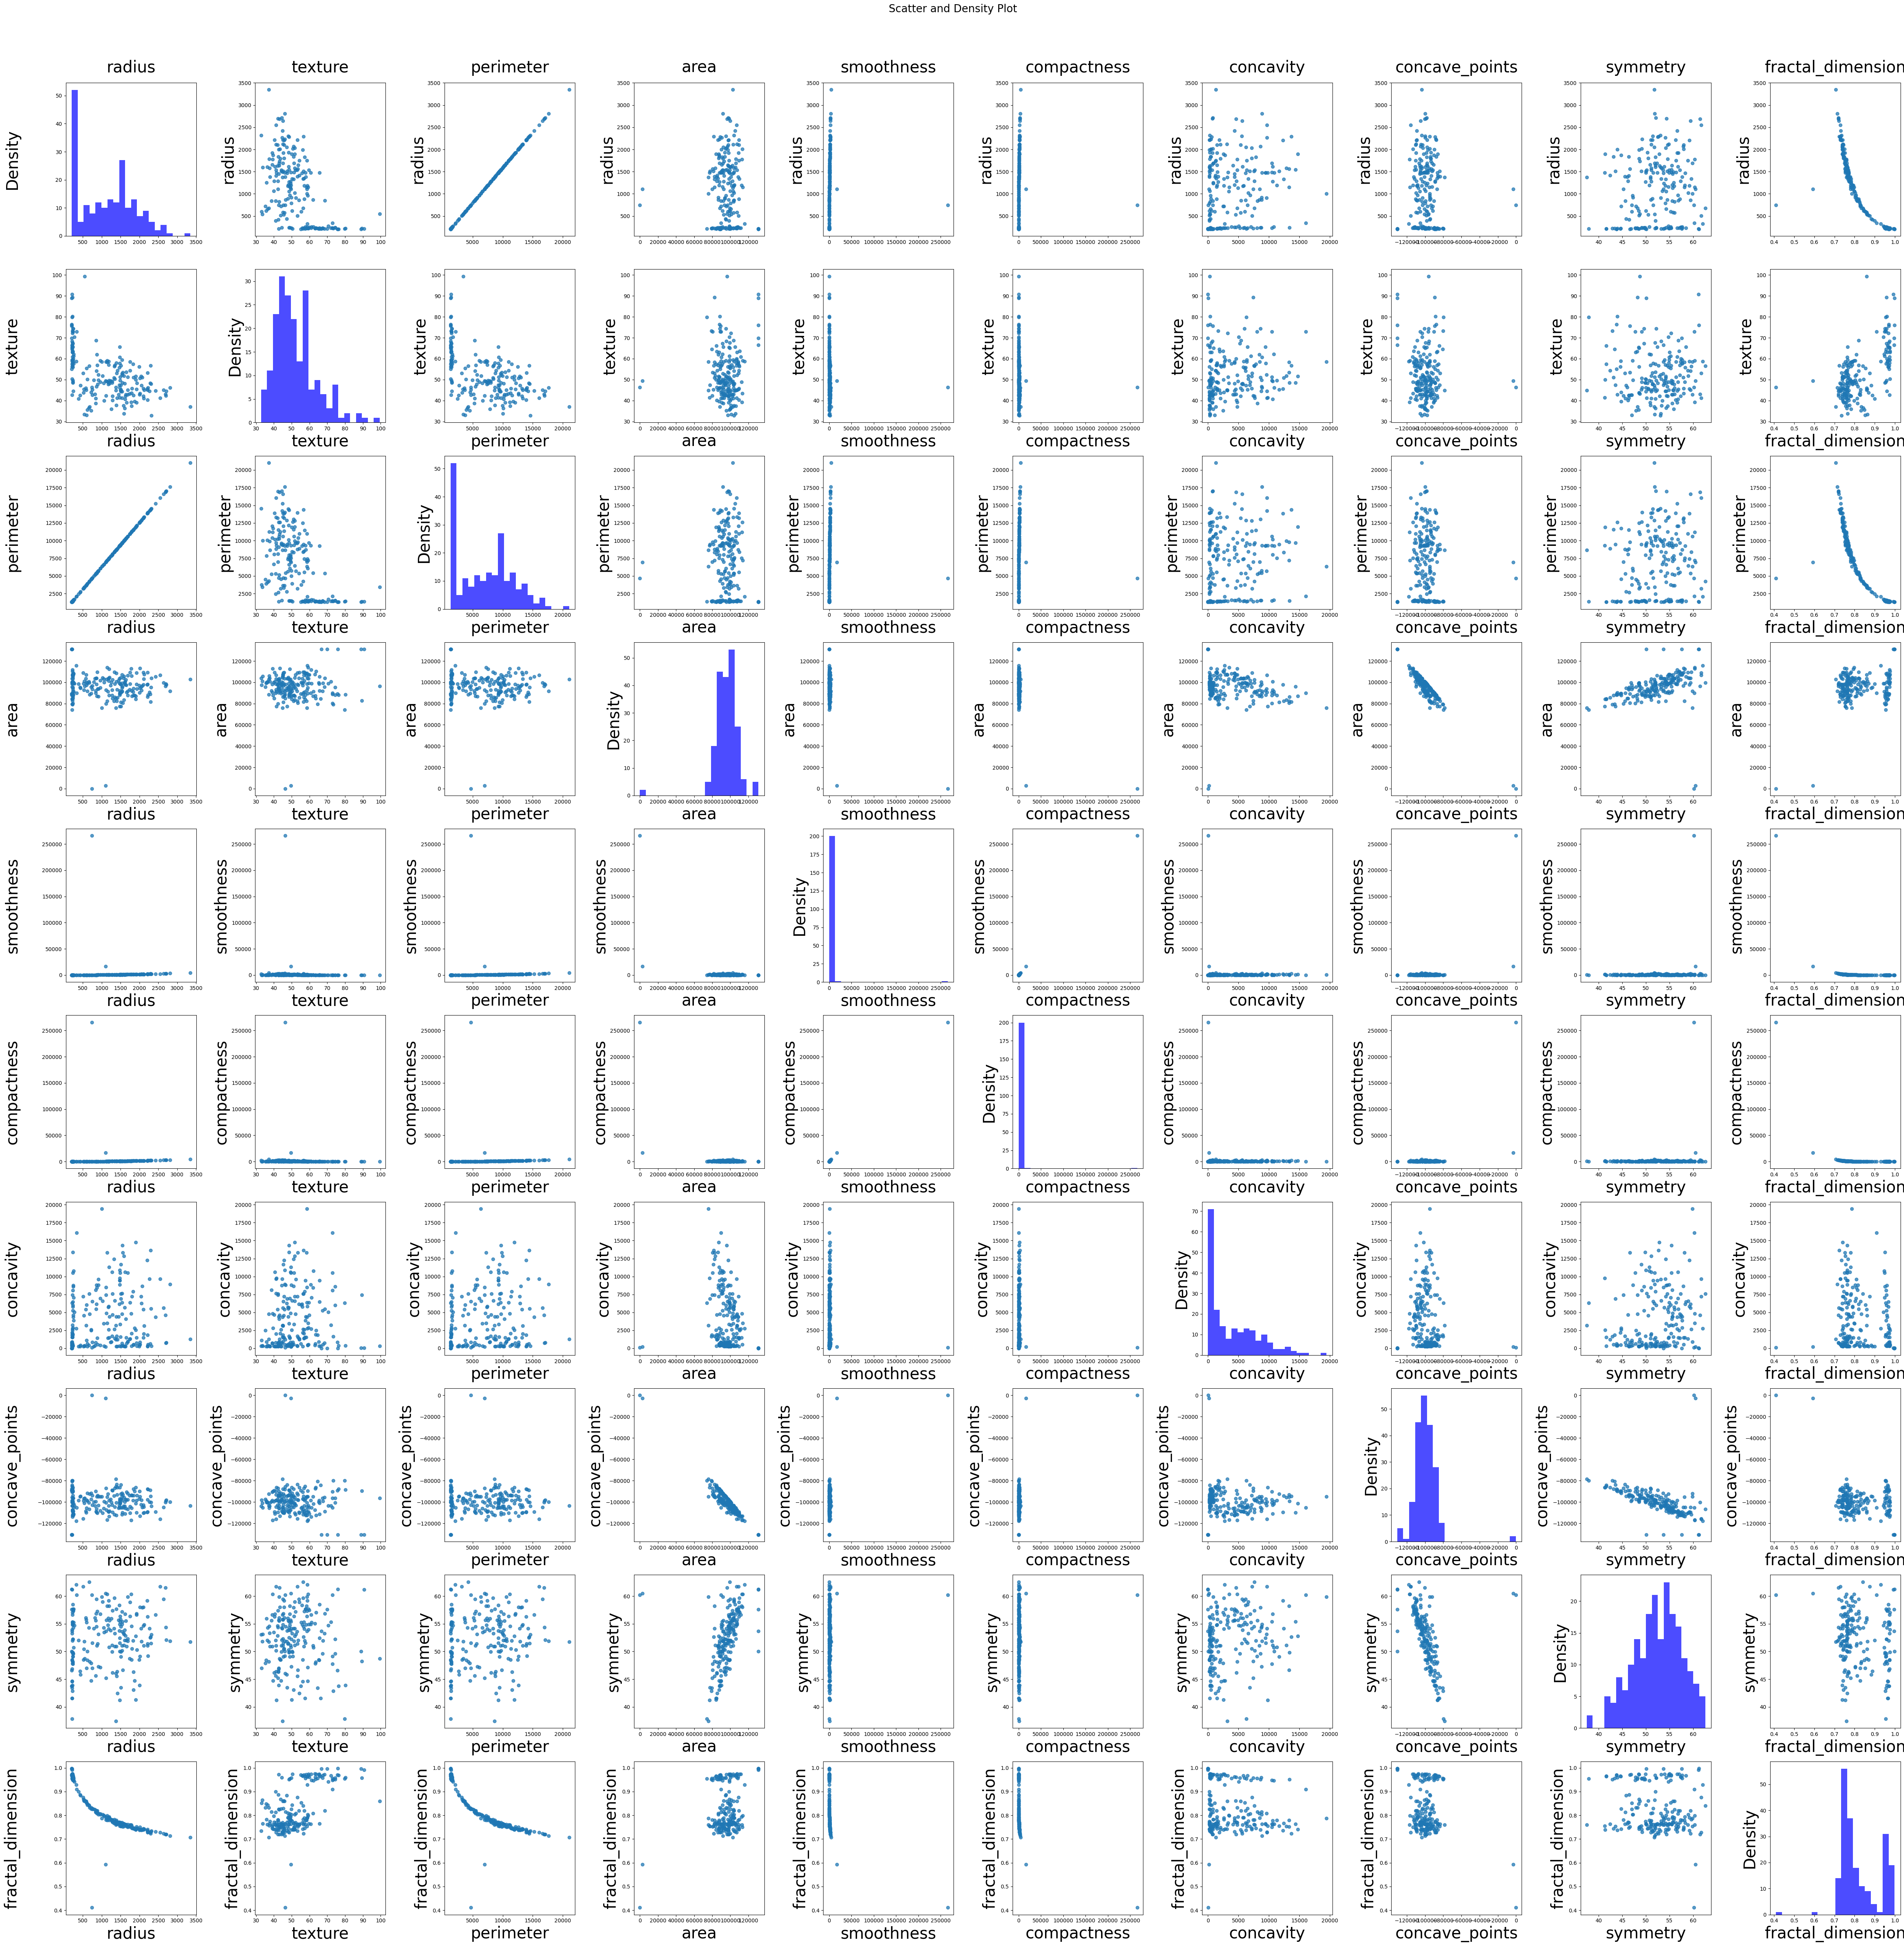

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number]) # keep only numerical columns
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    num_plots = len(df.columns)
    fig, axes = plt.subplots(nrows=num_plots, ncols=num_plots, figsize=(plotSize*num_plots, plotSize*num_plots))

    for i in range(num_plots):
        for j in range(num_plots):
            ax = axes[i, j]

            if i == j:
                ax.hist(df.iloc[:, i], bins=20, color='blue', alpha=0.7)
                ax.yaxis.tick_left()
                ax.xaxis.tick_bottom()
                ax.set_xlabel(df.columns[i], fontsize=textSize)
                ax.set_ylabel('Density', fontsize=textSize)
            else:
                ax.scatter(df.iloc[:, j], df.iloc[:, i], alpha=0.75)
                ax.yaxis.tick_left()
                ax.xaxis.tick_bottom()
                ax.yaxis.set_label_position('left')
                ax.xaxis.set_label_position('bottom')
                ax.set_xlabel(df.columns[j], fontsize=textSize)
                ax.set_ylabel(df.columns[i], fontsize=textSize)

            if i == 0:
                ax.xaxis.set_label_coords(0.5, 1.15)
            if j == 0:
                ax.yaxis.set_label_coords(-0.35, 0.5)

            cor = df.corr().iloc[i, j]
            # ax.annotate('Corr. coef = %.3f' % cor, xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', size=textSize)
            # ax.annotate(xycoords='axes fraction', ha='center', va='center', size=textSize)

    plt.suptitle('Scatter and Density Plot', y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming 'train_df' is the DataFrame you want to visualize
plotCorrelationMatrix(train_df, graphWidth=6)
plotScatterMatrix(train_df, plotSize=5, textSize=30)

In [ ]:
#Remove the memory code after testing
# Sample 1
process = psutil.Process()
before_memory = process.memory_info().rss / 1024 / 1024  # Convert to MB
print("process", process, "before Memory", before_memory)

process psutil.Process(pid=733, name='python3', status='running', started='12:15:34') before Memory 583.71484375


In [ ]:
X_train_reorder = np.random.permutation(X_train)

knn = KNeighborsClassifier()

params_knn = {"n_neighbors": np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=10)
knn_gs.fit(X_train, y_train)
knn_gs.fit(X_train_reorder, y_train)

best_params = knn_gs.best_params_
best_score = knn_gs.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

used_algorithm = knn.algorithm

knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_)

rf = RandomForestClassifier()
params_rf = {"n_estimators": [50, 100, 200]}
rf_gs = GridSearchCV(rf, params_rf, cv=10)
rf_gs.fit(X_train, y_train)
rf_gs.fit(X_train_reorder, y_train)


rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)
rf_best_params = rf_gs.best_params_
rf_best_score = rf_gs.best_score_

# print("Best Parameters:", rf_best_params)
# print("Best Score:", rf_best_score)
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)

print("knn: {}".format(knn_best.score(X_test, y_test)))
print("rf: {}".format(rf_best.score(X_test, y_test)))


estimators=[("knn", knn_best), ("rf", rf_best)]
ensemble = VotingClassifier(estimators, voting="hard")
# ensemble = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

ensemble.fit(X_train, y_train)

ens_best = ensemble.score(X_test, y_test)
print("Ens_best", ens_best)

y_pred = ensemble.predict(X_test)
y_pred_labels = y_pred

ens_labels = ensemble.predict(X_test)

score1 = knn_best.score(X_test, y_test)
score2 = rf_best.score(X_test, y_test)



Best Parameters: {'n_neighbors': 2}
Best Score: 0.5937908496732026
{'n_neighbors': 2}
{'n_estimators': 200}
knn: 0.696969696969697
rf: 0.5075757575757576


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Ens_best 0.5303030303030303


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
def image_generator(X, y, batch_size=32):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        batch_indices = []
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices.extend(indices[start:end])

            if len(batch_indices) == batch_size:
                batch_X = np.zeros((batch_size, 224, 224, 3))
                batch_y = np.zeros((batch_size,))  # Use num_classes from your problem

                for i, idx in enumerate(batch_indices):
                    if idx >= num_samples:
                        continue  # Skip this sample

                    if "path" not in X.iloc[idx]:
                        continue  # Skip this sample if 'path' key is missing

                    path = X.iloc[idx]["path"]
                    image = load_and_preprocess_image(path)
                    if image is None:
                        continue  # Skip this sample

                    batch_X[i] = image
                    batch_y[i] = y.iloc[idx]

                yield batch_X, batch_y
                batch_indices = []

        # If there are remaining samples that don't form a full batch, process them as well
        if batch_indices:
            batch_X = np.zeros((len(batch_indices), 224, 224, 3))
            batch_y = np.zeros((len(batch_indices), 10))  # Use num_classes from your problem
            for i, idx in enumerate(batch_indices):
                if idx >= num_samples:
                    continue  # Skip this sample

                if "path" not in X.iloc[idx]:
                    continue  # Skip this sample if 'path' key is missing

                path = X.iloc[idx]["path"]
                image = load_and_preprocess_image(path)

                if image is None:
                    continue  # Skip this sample

                batch_X[i] = image
                batch_y[i] = y.iloc[idx]

            yield batch_X, batch_y

def load_and_preprocess_image(path):
    image = cv2.imread(path)
    if(image is not None):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0
    return image

X_train = train_df.drop(columns=["label", "path_id"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "path_id"])
y_test = test_df["label"]
# print("X_test", X_test, "y_test", y_test)

In [ ]:
def run_code():
    base_model = EfficientNetB7(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # train_generator = image_generator(X_train, y_train)
    # test_generator = image_generator(X_test, y_test)
    # train_generator = image_generator(X_train, y_train, len(y_train))
    # test_generator = image_generator(X_test, y_test, len(y_test))
    train_generator = image_generator(X_train, y_train, 250)
    test_generator = image_generator(X_test, y_test, 250)

    X_train_processed, y_train_processed = next(train_generator)
    X_test_processed, y_test_processed = next(test_generator)

    epochs = 10
    accuracy_history = []
    loss_history = []

    for epoch in range(epochs):
        history = model.fit(X_train_processed, y_train_processed, epochs=1, validation_data=(X_test_processed, y_test_processed))
        # Access training accuracy and loss for the current epoch
        training_accuracy = history.history['accuracy'][0]
        training_loss = history.history['loss'][0]

        # Access validation accuracy and loss for the current epoch
        validation_accuracy = history.history['val_accuracy'][0]
        validation_loss = history.history['val_loss'][0]

        # Append the accuracy and loss values for the current epoch to history
        accuracy_history.append(training_accuracy)
        loss_history.append(training_loss)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training loss: {training_loss:.4f}, Training accuracy: {training_accuracy:.4f}")
        print(f"Validation loss: {validation_loss:.4f}, Validation accuracy: {validation_accuracy:.4f}")

    # model.fit(X_train_processed, y_train_processed, validation_data=(X_test_processed, y_test_processed), epochs=10)

    print("Completed")
    test_loss, test_acc = model.evaluate(X_test_processed, y_test_processed)
    print("Test Loss:",test_loss, "Test accuracy:", test_acc)
    # Check the shape and data type of y_train_processed and y_test_processed

    # print("Training Analysis")
    # Assuming y_test_processed contains binary labels (0 and 1)
    # y_pred_train = model.predict(X_train_processed)
    # y_pred_train_labels = np.argmax(y_pred_train, axis=1)  # Convert probabilities to binary labels

    # # Generate classification report
    # report_train = classification_report(y_train_processed,y_pred_train_labels)
    # print(report_train)
    # # Convert the data type of y_test_processed to integer
    # y_train_processed = y_train_processed.astype(int)

    # # Generate the confusion matrix
    # cm = confusion_matrix(y_train_processed, y_pred_train_labels)

    # # Print the confusion matrix
    # print("Confusion Matrix:")
    # print(cm)
    # print("confusion_matrix", cm)
    # # Calculate the F1 score
    # f1 = f1_score(y_train_processed, y_pred_train_labels, average='macro')
    # print("F1 Score:", f1)

    # print("Testing Analysis")
    # Assuming y_test_processed contains binary labels (0 and 1)
    y_pred = model.predict(X_test_processed)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to binary labels

    # Generate classification report
    report = classification_report(y_test_processed, y_pred_labels)
    print(report)
    # Convert the data type of y_test_processed to integer
    y_test_processed = y_test_processed.astype(int)

    # Get predicted labels from the model
    y_pred = model.predict(X_test_processed)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_processed, y_pred_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)
    print("confusion_matrix", cm)
    # Calculate the F1 score
    f1 = f1_score(y_test_processed, y_pred_labels, average='macro')
    print("F1 Score:", f1)

    # Plotting the accuracy and loss graphs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), accuracy_history, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), loss_history, label='Training Loss', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # epochs = len(accuracy_history)
    # #plot accuracy
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(1, epochs+1), accuracy_history, marker='o',linestyle='-', color='r')
    # plt.title('Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.grid(True)
    # plt.xticks(np.arange(1, epochs + 1))
    # plt.ylim(0, 1)
    # plt.show()

    # #plot loss
    # plt.plot(range(1, epochs+1), loss_history, marker='o',linestyle='-', color='b')
    # plt.title('Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.grid(True)
    # plt.xticks(np.arange(1, epochs + 1))
    # plt.ylim(0, 1)
    # plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test_processed, y_pred[:, 1])
    # auc_pr = auc(recall, precision)
    # Calculate AUC
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve with AUC value
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve with AUC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # # Plot precision-recall curve
    # plt.figure()
    # plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % auc_pr)
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title('Precision-Recall Curve')
    # plt.legend(loc='lower left')
    # plt.show()

    return 1


In [ ]:
# Method 1
run_code()
after_memory = process.memory_info().rss / 1024 / 1024  # Convert to MB
memory_usage = after_memory - before_memory

print("Memory usage:", memory_usage, "MB")

258076736/258076736 [==============================] - 9s 0us/step


InvalidArgumentError: ignored

In [ ]:
def image_generator(X, y, batch_size=32):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)  # Shuffle the indices at the beginning of each epoch
        batch_indices = []
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices.extend(indices[start:end])

            if len(batch_indices) == batch_size:
                batch_X = np.zeros((batch_size, 224, 224, 3))
                batch_y = np.zeros((batch_size,))
                for i, idx in enumerate(batch_indices):
                    path = X.iloc[idx]["path"]
                    image = load_and_preprocess_image(path)
                    label = y.iloc[idx]
                    X_modified = X.drop('path', axis=1)
                    X_modified['path_id'] = range(1, len(X_modified) + 1)

                    input_data = pd.DataFrame([X_modified.iloc[idx]])
                    prediction = ensemble.predict(input_data)

                    batch_X[i] = image
                    batch_y[i] = prediction
                yield batch_X, batch_y
                batch_indices = []  # Reset batch_indices for the next batch

        # If there are remaining samples that don't form a full batch, process them as well
        if batch_indices:
            batch_X = np.zeros((len(batch_indices), 224, 224, 3))
            batch_y = np.zeros((len(batch_indices),))
            for i, idx in enumerate(batch_indices):
                path = X.iloc[idx]["path"]
                image = load_and_preprocess_image(path)
                label = y.iloc[idx]
                X_modified = X.drop('path', axis=1)
                X_modified['path_id'] = range(1, len(X_modified) + 1)

                input_data = pd.DataFrame([X_modified.iloc[idx]])
                prediction = ensemble.predict(input_data)

                batch_X[i] = image
                batch_y[i] = prediction
            yield batch_X, batch_y

def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

X_train = train_df.drop(columns=["label", "path_id"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "path_id"])
y_test = test_df["label"]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

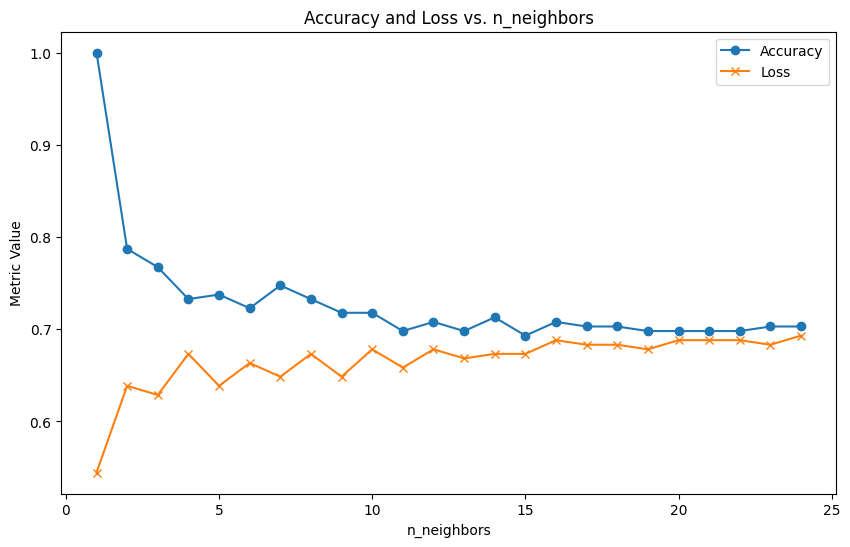

KeyboardInterrupt: ignored

In [ ]:
# Initialize lists to store accuracy and loss for each n_neighbors value
accuracy_history = []
loss_history = []

# Data
X_train_reorder = np.random.permutation(X_train)
params_knn = {"n_neighbors": np.arange(1, 25)}

for n_neighbors_value in params_knn['n_neighbors']:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors_value)

    knn_gs = GridSearchCV(knn, {"n_neighbors": [n_neighbors_value]}, cv=10)

    knn_gs.fit(X_train, y_train)

    # Access training accuracy and loss for the current n_neighbors value
    training_accuracy = knn_gs.best_estimator_.score(X_train, y_train)
    training_loss = knn_gs.best_estimator_.score(X_train_reorder, y_train)

    # Append accuracy and loss to the lists
    accuracy_history.append(training_accuracy)
    loss_history.append(training_loss)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(params_knn['n_neighbors'], accuracy_history, label='Accuracy', marker='o')
plt.plot(params_knn['n_neighbors'], loss_history, label='Loss', marker='x')
plt.xlabel('n_neighbors')
plt.ylabel('Metric Value')
plt.title('Accuracy and Loss vs. n_neighbors')
plt.legend()
plt.show()


X_train_reorder = np.random.permutation(X_train)
params_knn = {"n_neighbors": np.arange(1, 25)}

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn, params_knn, cv=10)

# Fit the model with the original X_train data
knn_gs.fit(X_train, y_train)

# Initialize lists to store accuracy and loss for each n_neighbors value
accuracy_history = []
loss_history = []

# Iterate through different values of n_neighbors
for n_neighbors_value in params_knn['n_neighbors']:
    # Set the current n_neighbors value
    knn_gs.best_estimator_.n_neighbors = n_neighbors_value

    # Get training accuracy and loss for the current n_neighbors value
    training_accuracy = knn_gs.best_estimator_.score(X_train, y_train)
    training_loss = knn_gs.best_estimator_.score(X_train_reorder, y_train)

    # Append accuracy and loss to the lists
    accuracy_history.append(training_accuracy)
    loss_history.append(training_loss)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(params_knn['n_neighbors'], accuracy_history, label='Accuracy', marker='o')
plt.plot(params_knn['n_neighbors'], loss_history, label='Loss', marker='x')
plt.xlabel('n_neighbors')
plt.ylabel('Metric Value')
plt.title('Accuracy and Loss vs. n_neighbors')
plt.legend()
plt.show()